# 序列到序列的学习
在翻译任务中，输入序列和输出序列是长度可变的，为了解决这种翻译问题，需要用到编码器-解码器架构，本节使用两个RNN的解码器和编码器，并将其运用到序列到序列(sequence to sequence)类的学习任务。

下面来构建编码器-解码器模型
## 编码器
编码器将长度可变的输入序列转换成形状固定的上下文变量$c$，并且将输入序列的信息在$c$中进行编码。

假设输入序列是 $x_1,x_2,\dots,x_T$，其中$x_t$是输入文本序列中的第t个词元，在时间步$t$，循环神经网络将$x_t$的输入特征向量 $\mathbf{x}_t$ 和 $\mathbf{h}_{t-1}$转换为 $\mathbf{h}_t$使用函数$f$来表示就是：
$$\mathbf{h}_t = f(\mathbf{x}_t,\mathbf{h}_{t-1})$$
然后，编码器通过选定函数$q$来将所有的隐状态转换为上下文变量：
$$\mathbf{c} = q(\mathbf{h}_1,\dots,\mathbf{h}_T)$$



In [2]:
# 首先import一大堆东西
import collections
import math
import torch as t
import torch.nn as nn
import sys
sys.path.append("../")
from pltutils import *
# 定义模型
class Encoder(nn.Module):
    def __init__(self,**kwargs):
        super(Encoder,self).__init__(**kwargs)
    
    def forward(self,X:t.Tensor,*args):
        raise NotImplementedError

class Decoder(nn.Module):
    def __init__(self,**kwargs):
        super(Decoder,self).__init__(**kwargs)
    
    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
        
    def forward(self,X:t.Tensor,state):
        raise NotImplementedError
        
class EncoderDecoder(nn.Module):
    def __init__(self,encoder:Encoder,decoder:Decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,enc_X:t.Tensor,dec_X:t.Tensor,*args)->tuple[t.Tensor,t.Tensor]:
        """
        前向传播函数
        """
        enc_outputs=self.encoder(enc_X,*args)
        dec_state=self.decoder.init_state(enc_outputs,*args)
        return self.decoder.forward(dec_X,dec_state)

In [3]:
# 定义序列到序列的编码器
class Seq2SeqEncoder(Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        # 定义嵌入层
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout)

    def forward(self,X:t.Tensor,*args):
        # X.shape = [batch_size,num_steps,emb_size]
        X=self.embedding.forward(X)
        # 第一个轴对应时间步 , equals = Tensor.transpose(1,0,2)
        X= X.permute(1,0,2)
        # 如果没有提及状态，默认为0
        output,state=self.rnn.forward(X)
        # output.shape = [num_steps,batch_size,num_hiddens]
        # 在这里 output还要经过线性层才能够输出想要的维度
        # state[0].shape =[num_layers,batch_size,num_hiddens]
        return output,state


In [4]:
# 尝试给Seqencoder一个小批量数据，查看结果
encoder= Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
input_data = t.ones((100,10),dtype=t.long)

output,state = encoder.forward(input_data)

output.shape,state.shape
#分别为 [num_steps,batch_size,hidden_size]和[num_layers,batch_size,num_hiddens]

(torch.Size([10, 100, 16]), torch.Size([2, 100, 16]))

# 解码器模型
解码器输出的上下文变量$c$对整个输入序列$x_1,\dots,x_T$进行编码。来自训练数据集的输出序列$y_1,y_2,\dots,y_{T'}$对于每个时间步$t'$，解码器输出$y_{t'}$的概率取决于之前的输出子序列和上下文变量$c$，即$P(y_{t'} \mid y_1,\dots,y_{t'-1},\mathbf c)$，为了在序列上模型化这种概率，也可以使用RNN来进行解码，对于输出序列上的任意时间步$t'$，RNN将来上一时间步的输出$y_{t'-1}$和上下文变量$\mathbf {c}$作为输入，然后在当前时间步将它们和隐状态$\mathbf {s}_{t'-1}$转换为隐状态$s_{t'}$即：
$$\mathbf s_{t'}=g(y_{t'-1},\mathbf c, \mathbf s_{t'-1})$$

In [5]:
class Seq2SeqDecoder(Decoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        self.embedding=nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size+num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense=nn.Linear(num_hiddens,vocab_size)

    def init_state(self,enc_outputs:t.Tensor,*args):
        return enc_outputs[1]
    
    def forward(self,X:t.Tensor,state:t.Tensor):
        X= self.embedding.forward(X).permute(1,0,2)
        # 复制上下文信息，对于每个时间步我们都有一样的上下文
        context=state[-1].repeat(X.shape[0],1,1)
        X_and_content=t.cat((X,context),2)
        output,state=self.rnn.forward(X_and_content,state)
        output = self.dense.forward(output).permute(1, 0, 2)
        return output,state

In [6]:
#搞两个数据试试
decoder = Seq2SeqDecoder(10,8,16,2)
decoder.eval()
state=decoder.init_state(encoder.forward(input_data))
output,state=decoder.forward(input_data,state)
output.shape,state.shape


(torch.Size([100, 10, 10]), torch.Size([2, 100, 16]))

# 损失函数设计
对于语言模型我们也可以进行softmax来获得分布，并计算交叉熵损失函数来进行优化，但是之前我们进行了填充，我们应该将填充词元的预测排除在损失函数的计算之外。

In [7]:
def sequence_mask(X:t.Tensor,valid_len:t.Tensor,value=0):
    """在序列中屏蔽不相关的项"""
    maxlen=X.size(1)
    mask=t.arange((maxlen),dtype=t.float32,device=X.device)[None,:]<valid_len[:,None]
    X[~mask]=value
    return X
X = t.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, t.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self,pred:t.Tensor,label:t.Tensor,valid_len:t.Tensor):
        # pred.shape = batch,step,vsize
        # label.shape =batch,step
        # valid_len.shape = batch,
        weights=t.ones_like(label)
        weights=sequence_mask(weights,valid_len)
        self.reduction="none"
        pred=pred.permute(0,2,1)
        unweighted_loss=super().forward(pred,label)
        weighted_loss=(unweighted_loss*weights).mean(dim=1)
        return weighted_loss

loss= MaskedSoftmaxCELoss()
loss(t.ones(3,4,10),t.ones((3,4),dtype=t.long),t.tensor([4,2,0]))

tensor([2.3026, 1.1513, 0.0000])

# 训练
特定的开始词元\<bos\>和原始的输出序列拼接在一起作为解码器的输入，被称为强制教学，因为原始的输出序列被送入解码器。

In [9]:
def train_seq2seq(net:nn.Module,data_iter,lr,num_epochs,tgt_vocab,device:t.device):

    def xavier_init_weights(m:nn.Module):
        if type(m)==nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m)==nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer=t.optim.Adam(net.parameters(),lr=lr)
    loss=MaskedSoftmaxCELoss()
    net.train()
    animator=Animator(xlabel="epoch",ylabel="loss",xlim=[10,num_epochs])

    for epoch in range(num_epochs):
        timer=Timer()
        metric=Accumulator(2)

        for batch in data_iter:
            optimizer.zero_grad()
            # to device
            X,X_valid_len,Y,Y_valid_len=[x.to(device) for x in batch]
            # 获取开始符的下标
            bos = t.tensor([tgt_vocab["<bos>"]]*Y.shape[0],device=device).reshape(-1,1)
            #在每个句子之前加上开始符
            dec_input = t.cat([bos,Y[:,:-1]],1)
            Y_hat,_=net.forward(X,dec_input,X_valid_len)
            l=loss.forward(Y_hat,Y,Y_valid_len)
            l.sum().backward()
            grad_clipping(net,1)
            num_tokens= Y_valid_len.sum()
            optimizer.step()
            with t.no_grad():
                metric.add(l.sum(),num_tokens)
        if (epoch+1)%10==0:
            animator.add(epoch+1,(metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

            

loss 0.019, 14928.0 tokens/sec on cuda:0


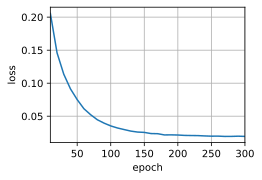

In [10]:
# 定义网络，数据集，损失函数，开始训练
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [11]:
# 预测
def predict_seq2seq(net:EncoderDecoder,src_sentence:str,src_vocab:Vocab,tgt_vocab:Vocab,num_steps,device,save_attention_weights=False):
    net.eval()
    src_tokens=src_vocab[src_sentence.lower().split(" ")]+[src_vocab["<eos>"]]
    enc_valid_len = t.tensor([len(src_tokens)],device=device)
    src_tokens=truncate_pad(src_tokens,num_steps,src_vocab["<pad>"])

    # 添加批量轴
    # 在第0维进行扩展，否则不能够丢进网络
    enc_X=t.unsqueeze(t.tensor(src_tokens,dtype=t.long,device=device),dim=0)
    enc_outputs=net.encoder.forward(enc_X,enc_valid_len)
    dec_state=net.decoder.init_state(enc_outputs)
    # 添加批量轴
    dec_X=t.unsqueeze(
        t.tensor([tgt_vocab["<bos>"]],dtype=t.long,device=device),dim=0
    )
    output_seq,attention_weight_seq=[],[]

    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [12]:
def bleu(pred_seq, label_seq, k):  # @save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


In [13]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')


go . => va !, bleu 1.000
i lost . => j'ai perdu ?, bleu 0.687
he's calm . => trouve tom ., bleu 0.000
i'm home . => je suis chez bon bien de question bon bon bon, bleu 0.376
